In [5]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [7]:
dup_subset = ['experiment', 'layers', 'optimizer', 'gamma_0', 'beta_0', 'cost']

dups = experiment_results[dup_subset]
dups = dups.groupby(dups.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)
dups = dups[dups['size']>1]

if not dups.empty:
    print('Duplicates found!')
    display(dups[['experiment', 'optimizer', 'gamma_0', 'beta_0']].drop_duplicates().head())

experiment_results = experiment_results.drop_duplicates(subset=dup_subset).reset_index(drop=True)

In [8]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [9]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. It doesn't seem very appropriate for our problem,
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution
for high $p$. It is sensitive to initial conditions.

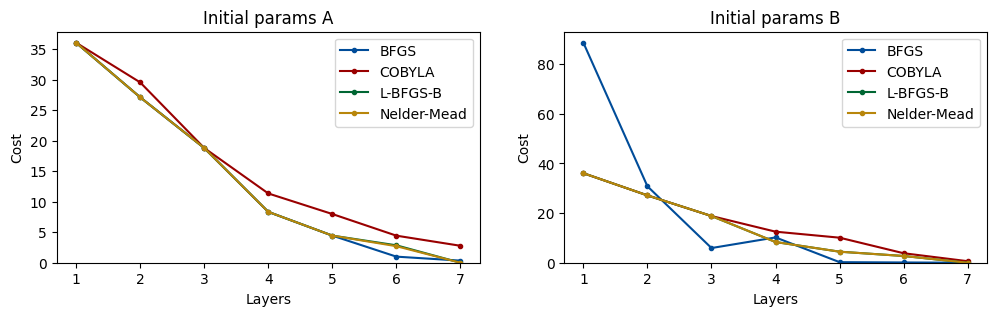

In [10]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

## Standard protocol

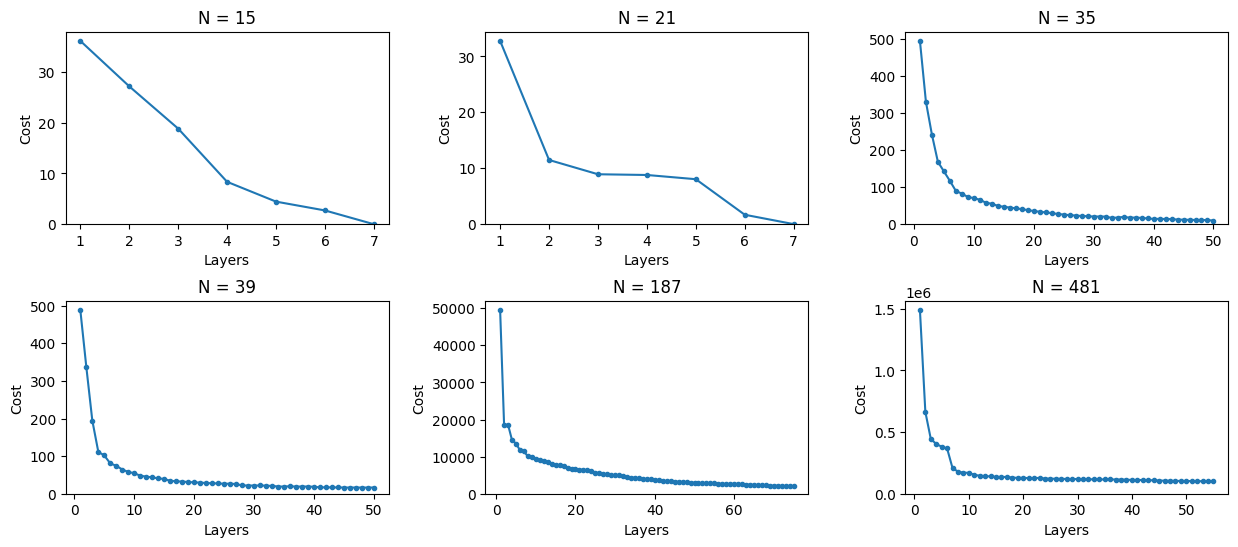

In [11]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    axs[i].plot('layers', 'cost', data=df_N, marker='.', label=optimizer)
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

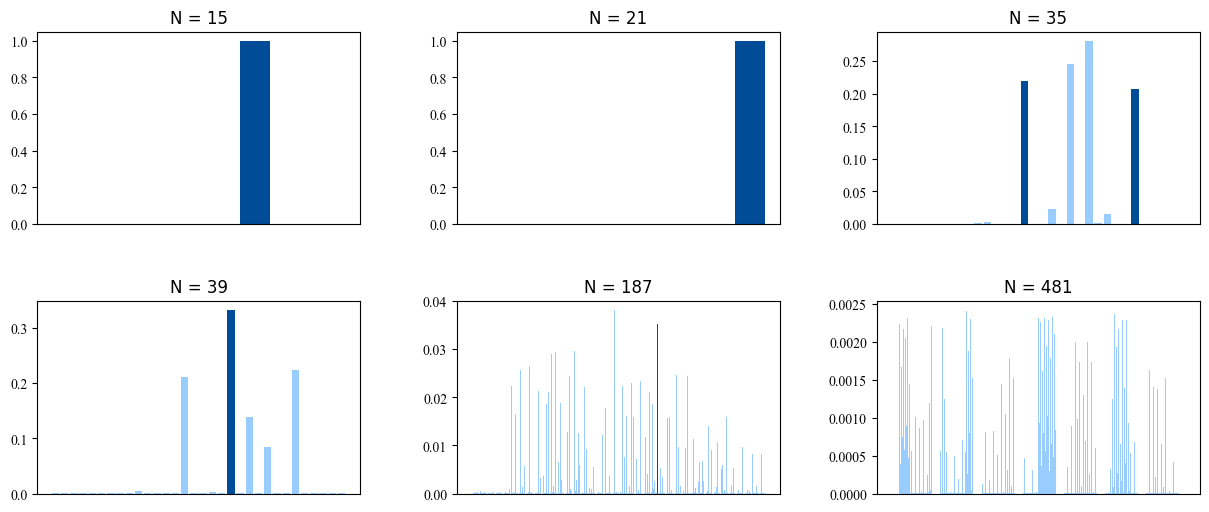

In [12]:
ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

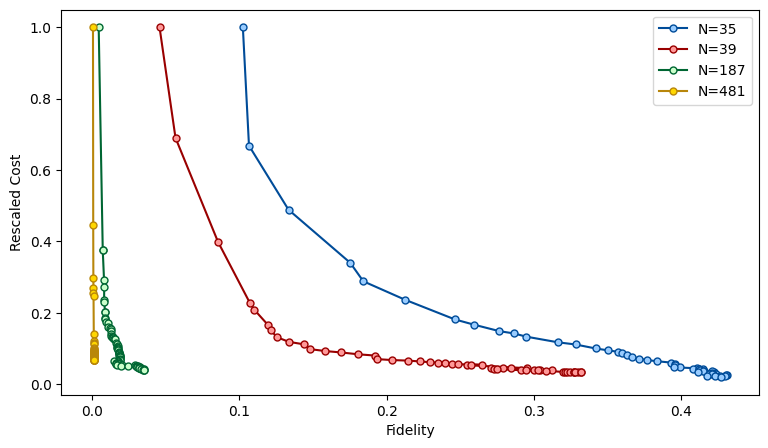

In [27]:
fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
plt.show()

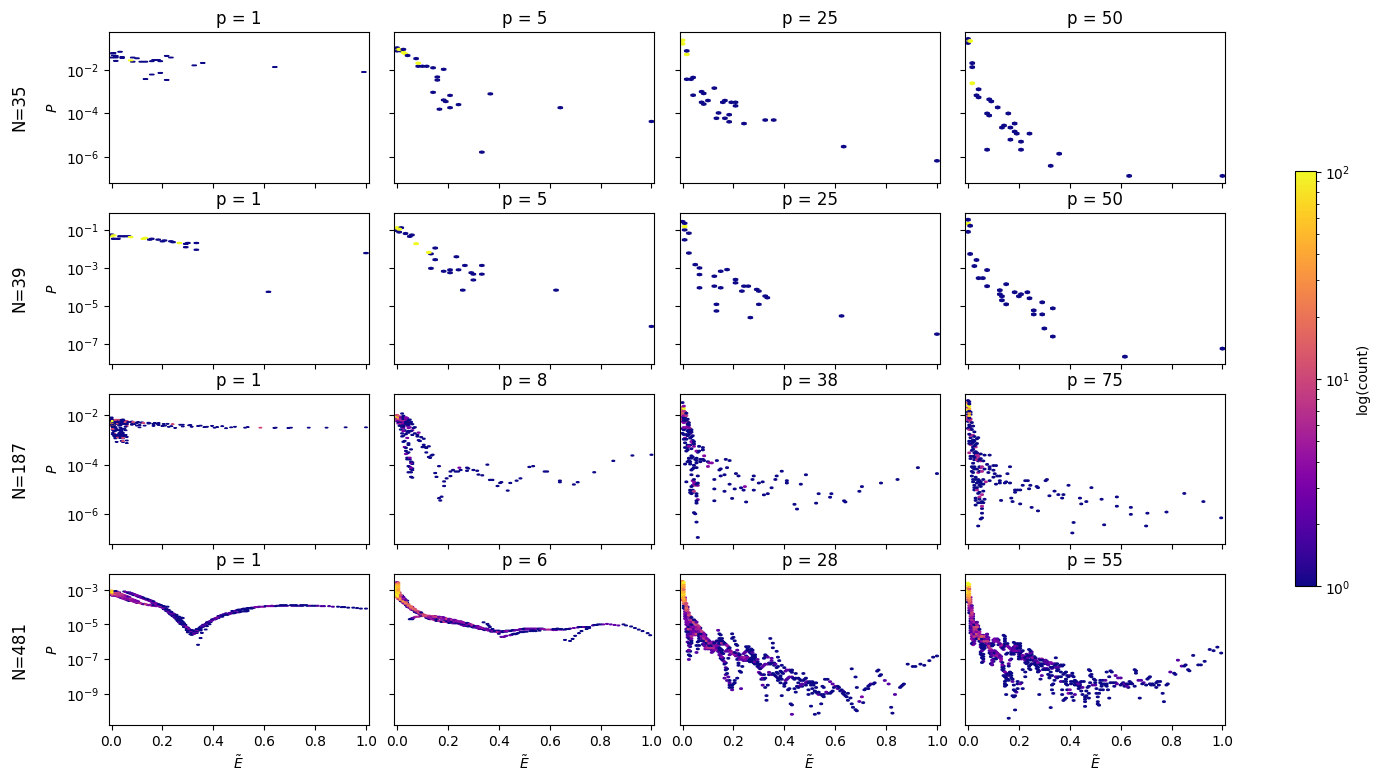

In [18]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']>=35)]

Ns = sorted(df['N'].unique())

n_samples = 4
fig, axs = plt.subplots(nrows=len(Ns), ncols=n_samples, figsize=(18, 9),sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1)

for idx_row, N in enumerate(Ns):
    df_N = df[(df['N']==N)]

    layer_max = df_N['layers'].max()
    n_samples = 4
    target_layers = [1, int(1+0.1*(layer_max-1)), int(1+0.5*(layer_max-1)), layer_max]
    
    for idx_col, p in enumerate(target_layers):
        
        df_p = df_N[df_N['layers']==p].copy()
        ax = axs[idx_row][idx_col]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        gridsize=60 if N < 187 else 100
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=gridsize, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        
        ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == len(Ns)-1:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.05)
        # ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=1)
        # ylim = 1e-6 if N < 187 else 1e-7
        # ax.set_ylim(ylim)

    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, f'N={N}', va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.6)

plt.show()

## Comparison between setups for BFGS

NameError: name 'experiment_results_agg' is not defined

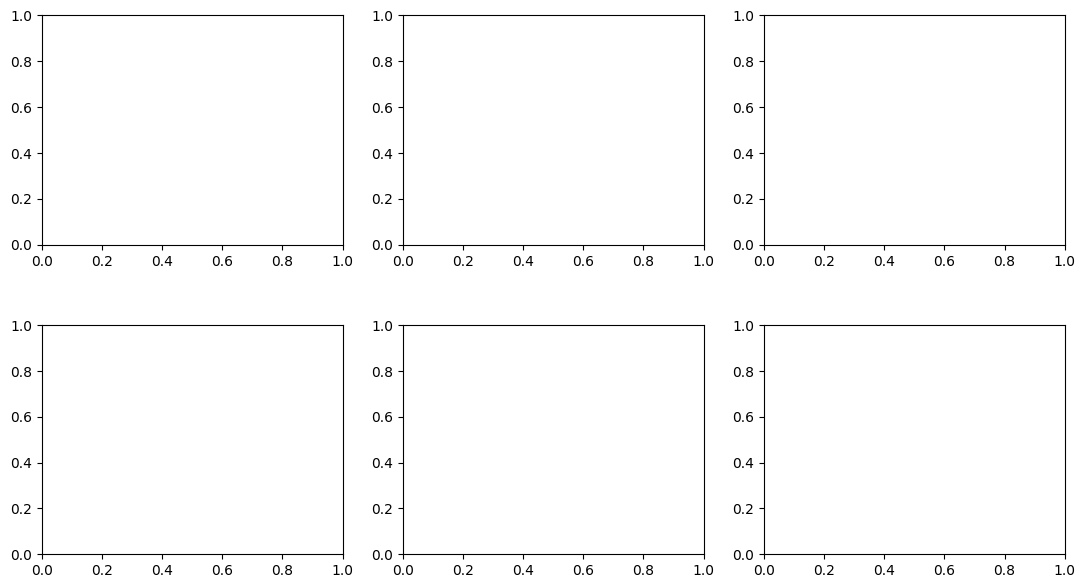

In [19]:
fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Comparison between setups for L-BFGS-B

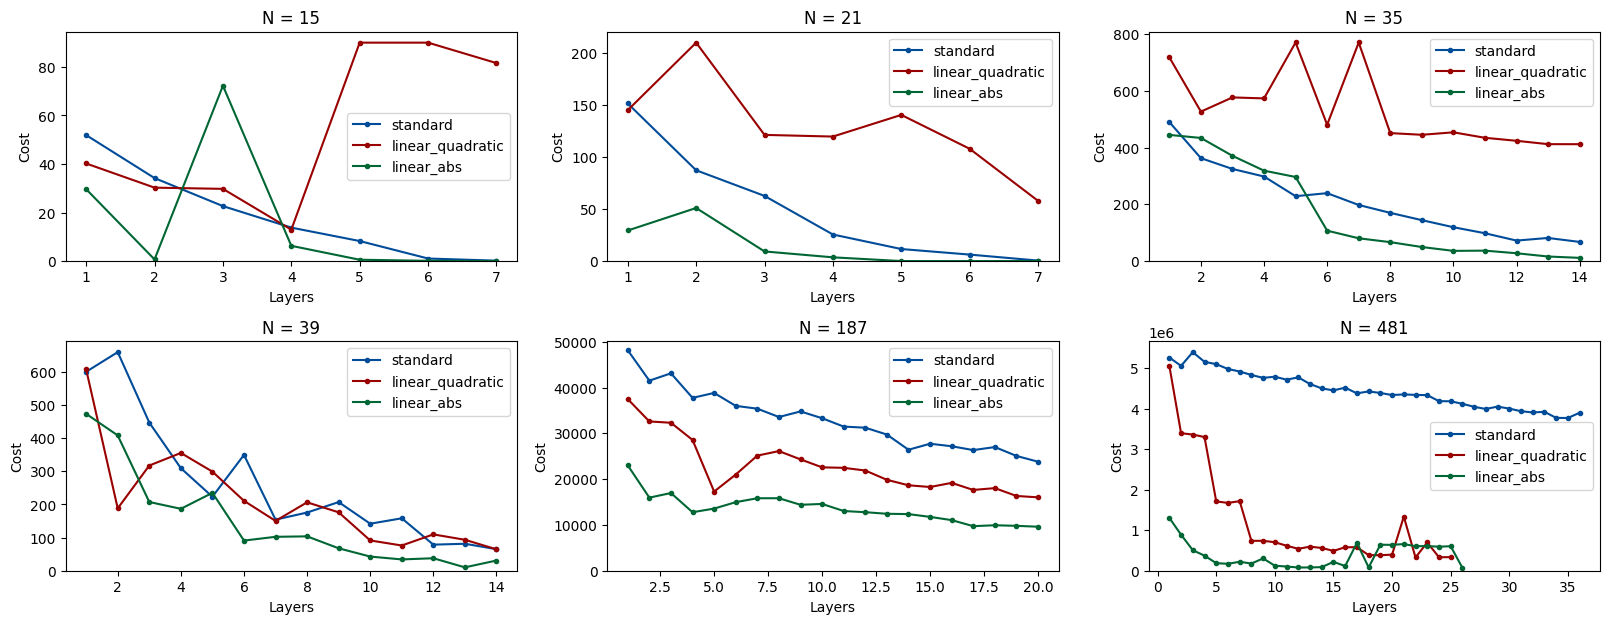

In [ ]:
fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'L-BFGS-B')]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Average Populations

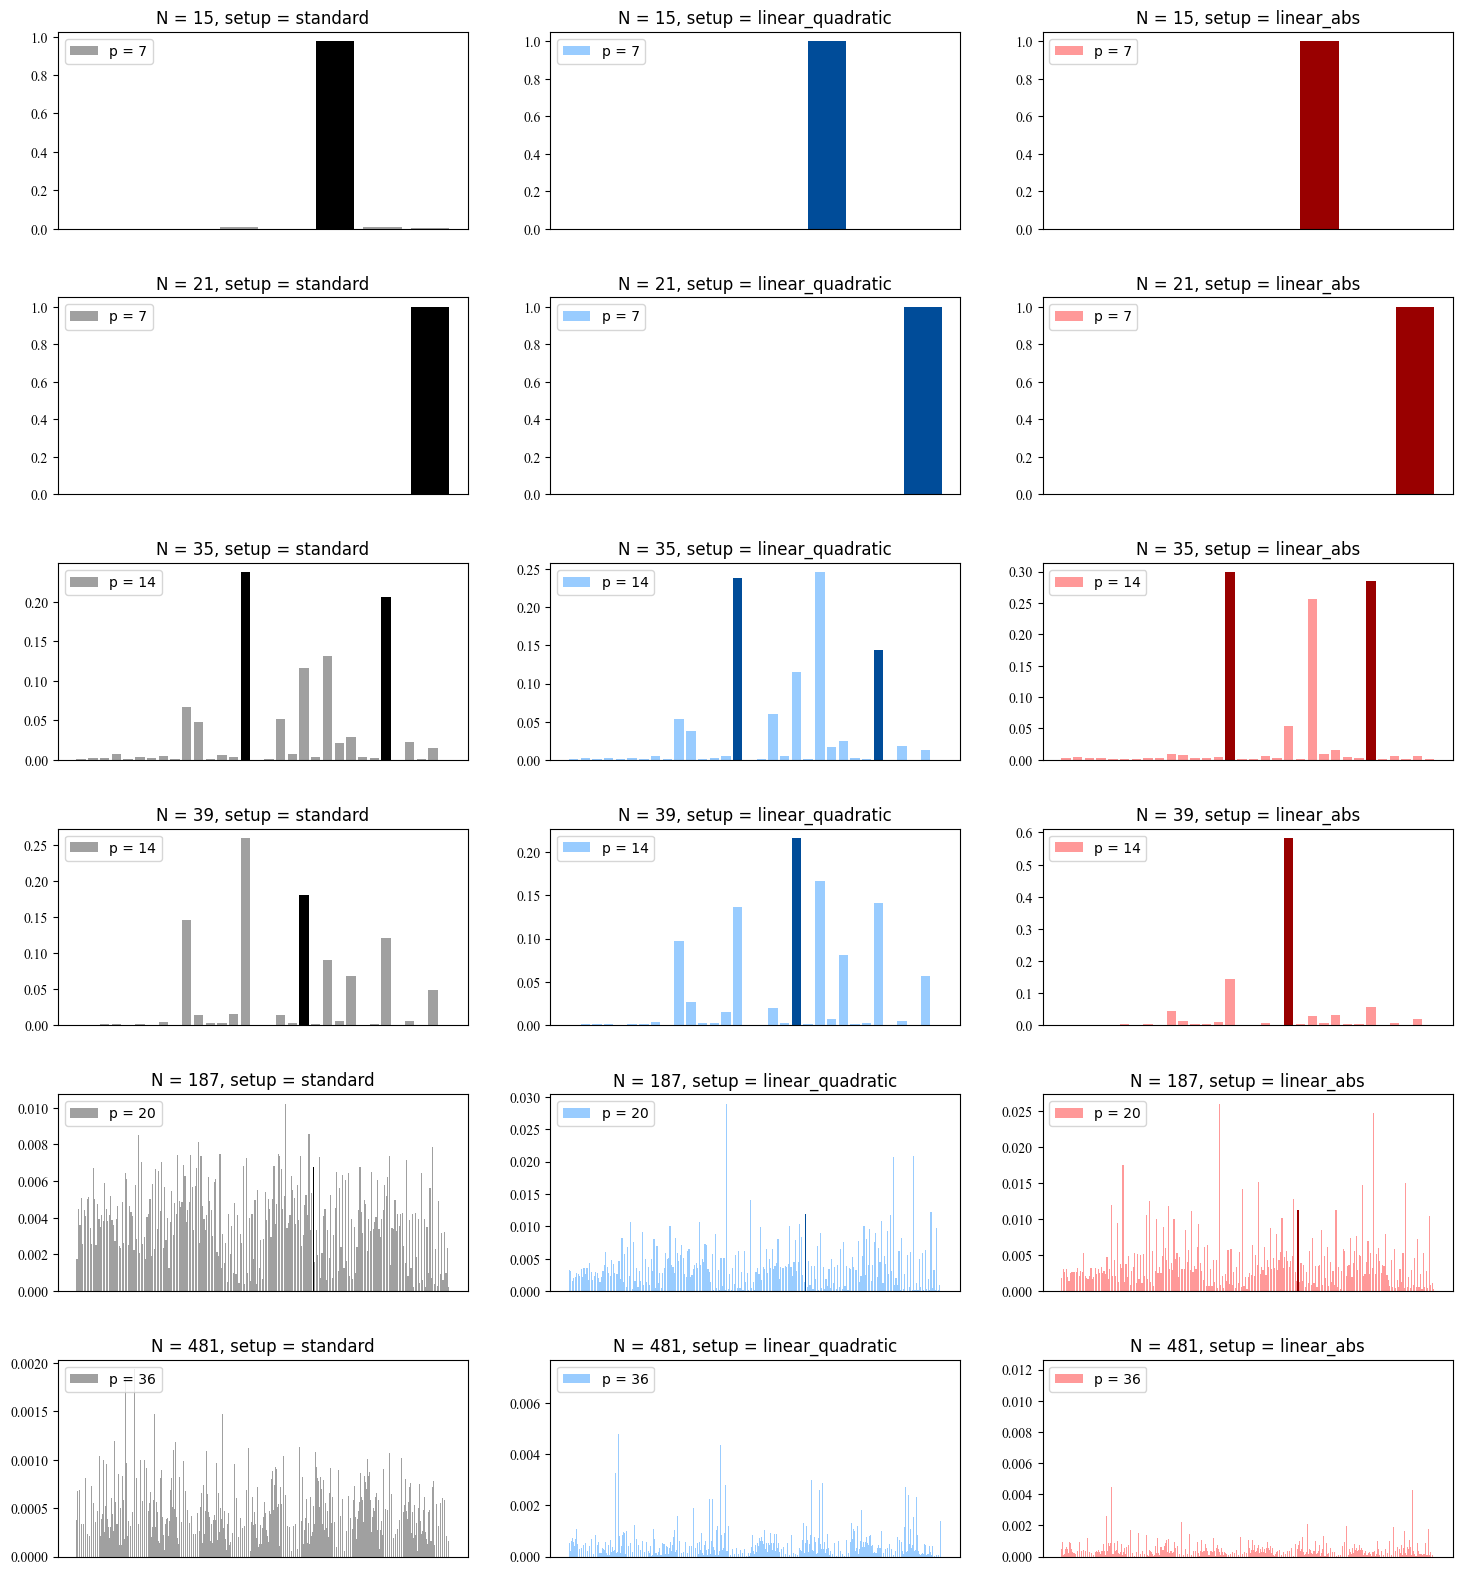

In [ ]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    max_layers = df_N['layers'].max()

    for j, setup in enumerate(setups):

        df_N_setup = df_N[(df_N['setup']==setup)]
        max_layers = df_N_setup['layers'].max()
        df =  df_N_setup[df_N_setup['layers']==max_layers].reset_index(drop=True).loc[0, 'populations_mean']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {max_layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

fig_name = f'plots/analysis_populations.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Best results

### By cost

In [ ]:
group_cols = ['N', 'setup']

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_results = experiment_results.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'state_populations', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,gamma_0,beta_0,state_populations,fidelity,cost,num_qubits
0,15,linear_abs,L-BFGS-B,7,3.428,1.861,"[2.2213940169317707e-10, 8.107282754043833e-10...",1.000000,8.662975e-08,3
1,15,linear_quadratic,L-BFGS-B,5,2.694,2.320,"[4.931016681837994e-12, 3.185194795596947e-12,...",1.000000,1.856609e-09,3
2,15,standard,BFGS,7,3.053,1.152,"[7.895131448234326e-15, 2.9922729391870412e-15...",1.000000,1.317679e-11,3
3,21,linear_abs,L-BFGS-B,7,2.694,2.320,"[2.2997235619669462e-11, 8.475137963020268e-11...",1.000000,1.050581e-08,3
4,21,linear_quadratic,BFGS,7,3.061,1.897,"[1.2884092325239485e-12, 4.940020124716064e-13...",1.000000,1.628092e-09,3
5,21,standard,BFGS,7,1.896,1.101,"[2.8763573830007438e-15, 2.9647716442466973e-1...",1.000000,7.790895e-12,3
6,35,linear_abs,BFGS,14,2.984,0.901,"[0.0003882041254432592, 0.00035410907959226737...",0.979980,3.676379e-01,5
7,35,linear_quadratic,BFGS,9,3.038,1.432,"[0.0003337168736033215, 0.0006909450384089343,...",0.847784,3.169192e+01,5
8,35,standard,BFGS,14,3.273,1.298,"[0.0005235734089477448, 0.0027202082445040836,...",0.518570,3.322960e+01,5
9,39,linear_abs,BFGS,13,1.901,0.926,"[0.0005605698230224867, 0.00022994575627501078...",0.942966,6.583005e-01,5


### By fidelity

In [ ]:
idx_min = experiment_results.groupby(group_cols)['fidelity'].idxmax()
best_results = experiment_results.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'state_populations', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,gamma_0,beta_0,state_populations,fidelity,cost,num_qubits
0,15,linear_abs,L-BFGS-B,7,3.428,1.861,"[2.2213940169317707e-10, 8.107282754043833e-10...",1.000000,8.662975e-08,3
1,15,linear_quadratic,L-BFGS-B,5,2.694,2.320,"[4.931016681837994e-12, 3.185194795596947e-12,...",1.000000,1.856609e-09,3
2,15,standard,BFGS,7,3.053,1.152,"[7.895131448234326e-15, 2.9922729391870412e-15...",1.000000,1.317679e-11,3
3,21,linear_abs,L-BFGS-B,7,2.694,2.320,"[2.2997235619669462e-11, 8.475137963020268e-11...",1.000000,1.050581e-08,3
4,21,linear_quadratic,BFGS,7,3.061,1.897,"[1.2884092325239485e-12, 4.940020124716064e-13...",1.000000,1.628092e-09,3
5,21,standard,BFGS,7,2.073,2.278,"[6.869179994821649e-15, 1.5899680808483635e-14...",1.000000,1.120620e-11,3
6,35,linear_abs,BFGS,14,2.984,0.901,"[0.0003882041254432592, 0.00035410907959226737...",0.979980,3.676379e-01,5
7,35,linear_quadratic,BFGS,9,4.050,0.902,"[0.0003337186791980223, 0.0006909475733505251,...",0.847784,3.169192e+01,5
8,35,standard,BFGS,14,1.047,1.047,"[0.0009099952564454205, 0.004593977470357765, ...",0.657452,8.509635e+01,5
9,39,linear_abs,BFGS,13,1.901,0.926,"[0.0005605698230224867, 0.00022994575627501078...",0.942966,6.583005e-01,5


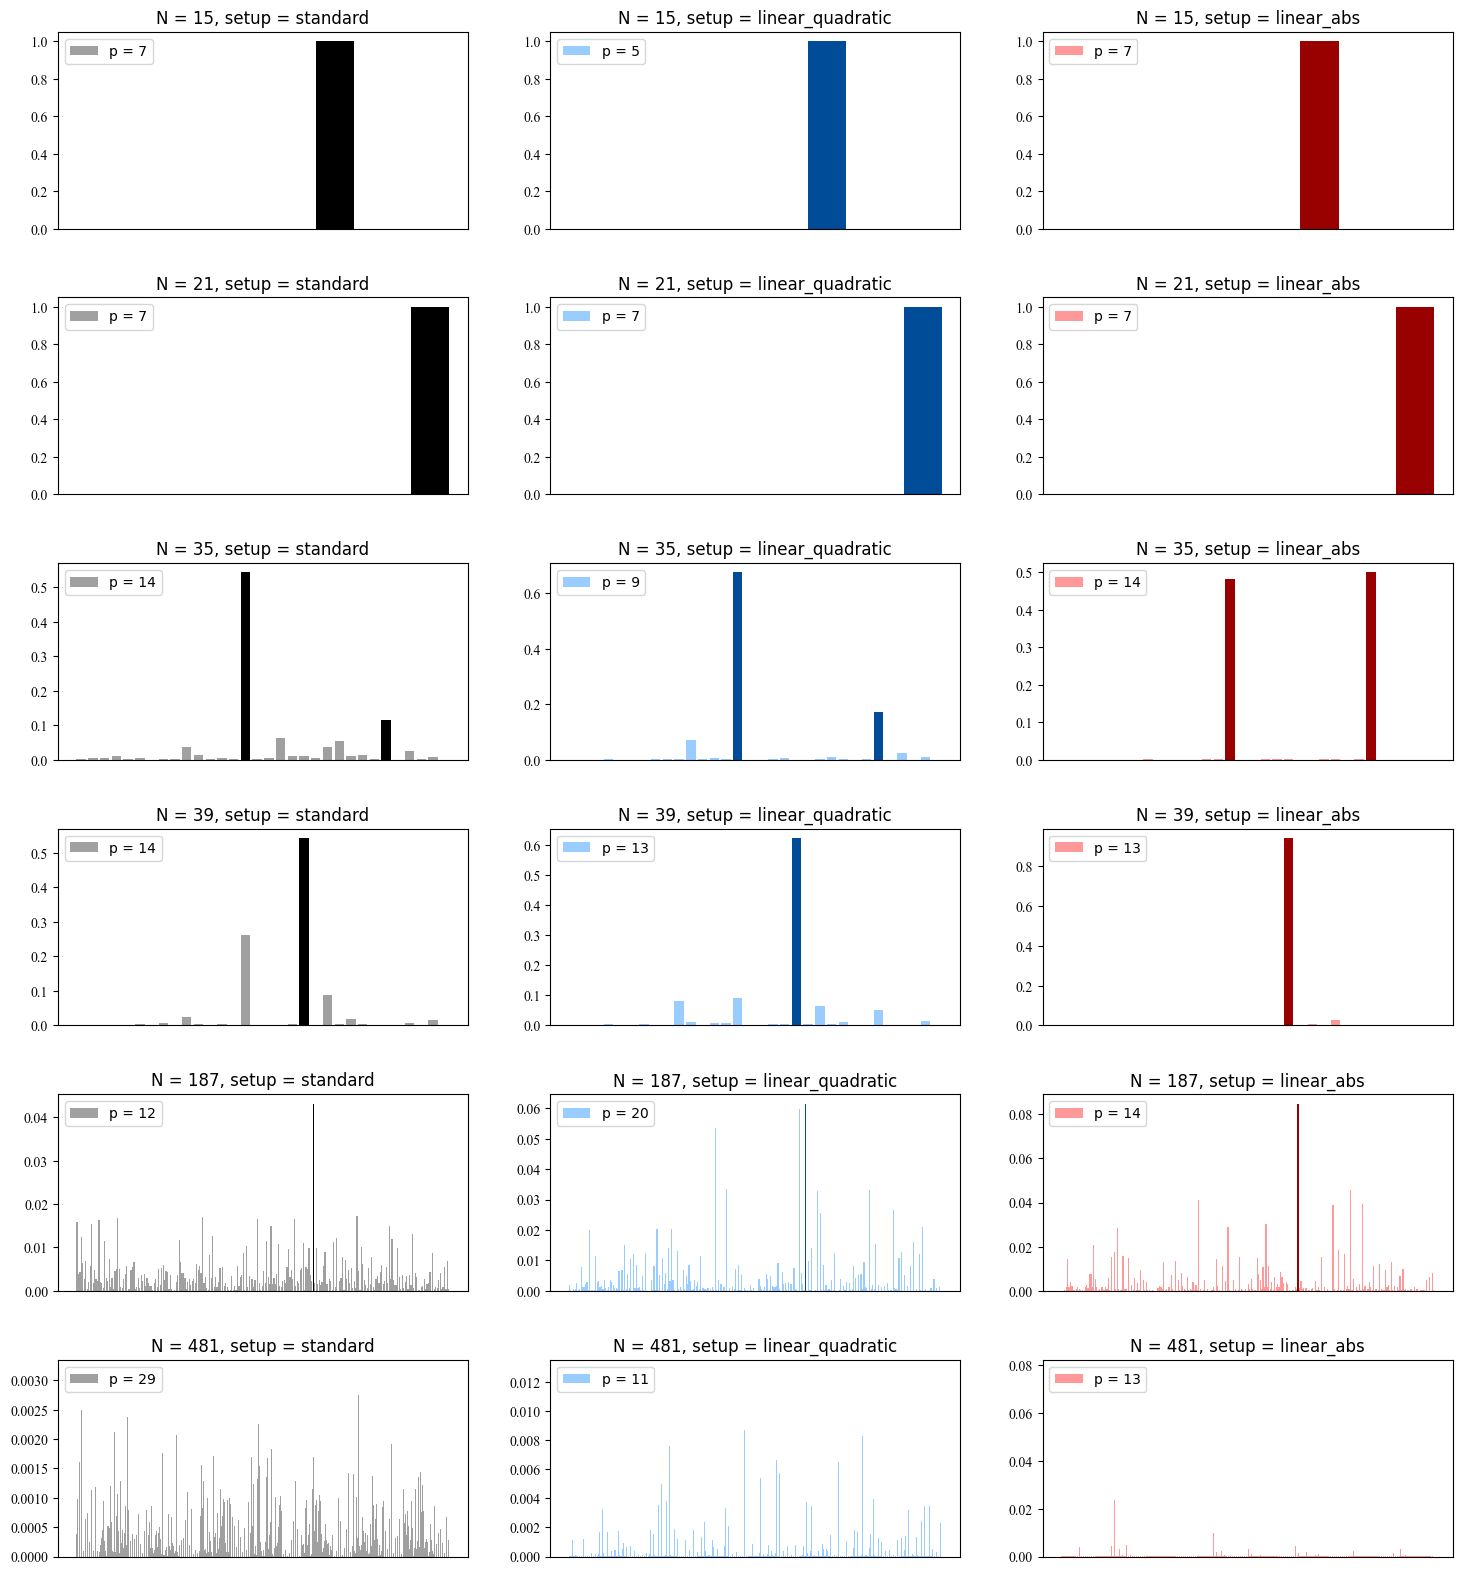

In [ ]:
Ns = sorted(best_results.N.unique())
setups = sorted(best_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = best_results[(best_results.N == N)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)
        layers = df_N_setup.loc[0, 'layers']
        df =  df_N_setup.loc[0, 'state_populations']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

## Cost-Fidelity correlations

TypeError: 'Axes' object is not subscriptable

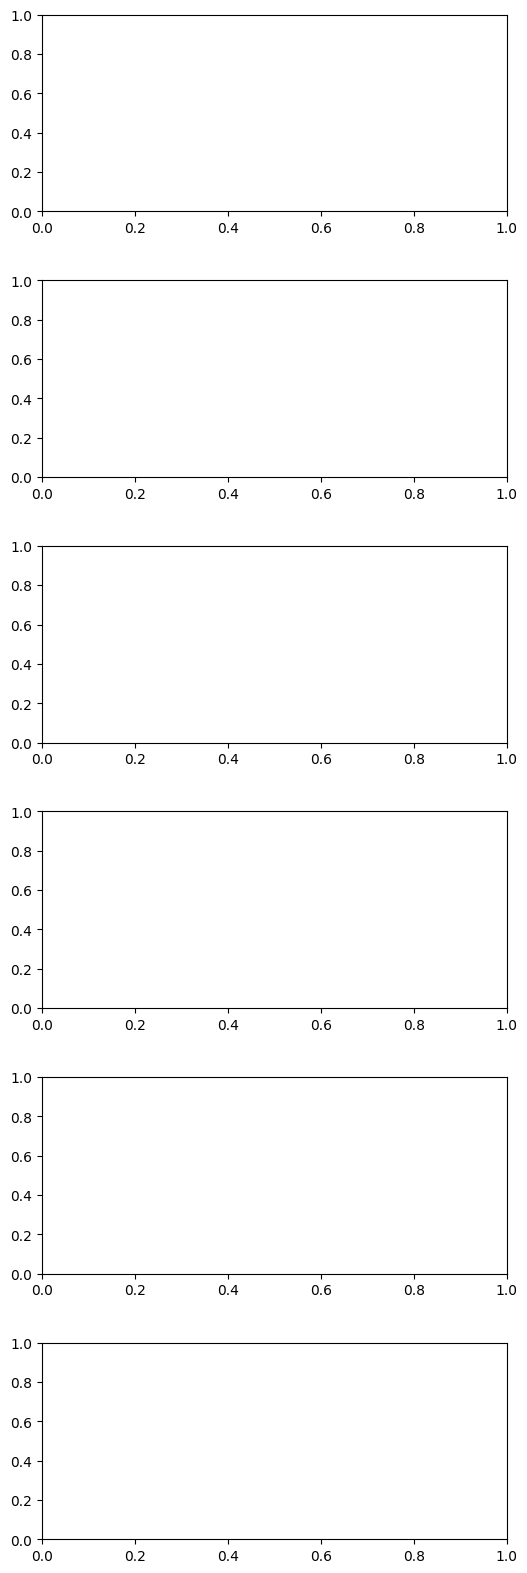

In [ ]:
Ns = sorted(experiment_results.N.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results[(experiment_results.N == N)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)

        scatter_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].scatter(df_N_setup['fidelity'], df_N_setup['cost'], s=8)
        axs[i][j].set_ylim(0)

        axs[i][j].set_title(f'N = {N}, setup = {setup}')
        axs[i][j].set_ylabel('Cost')
        axs[i][j].set_xlabel('Fidelity')

## Probability distributions

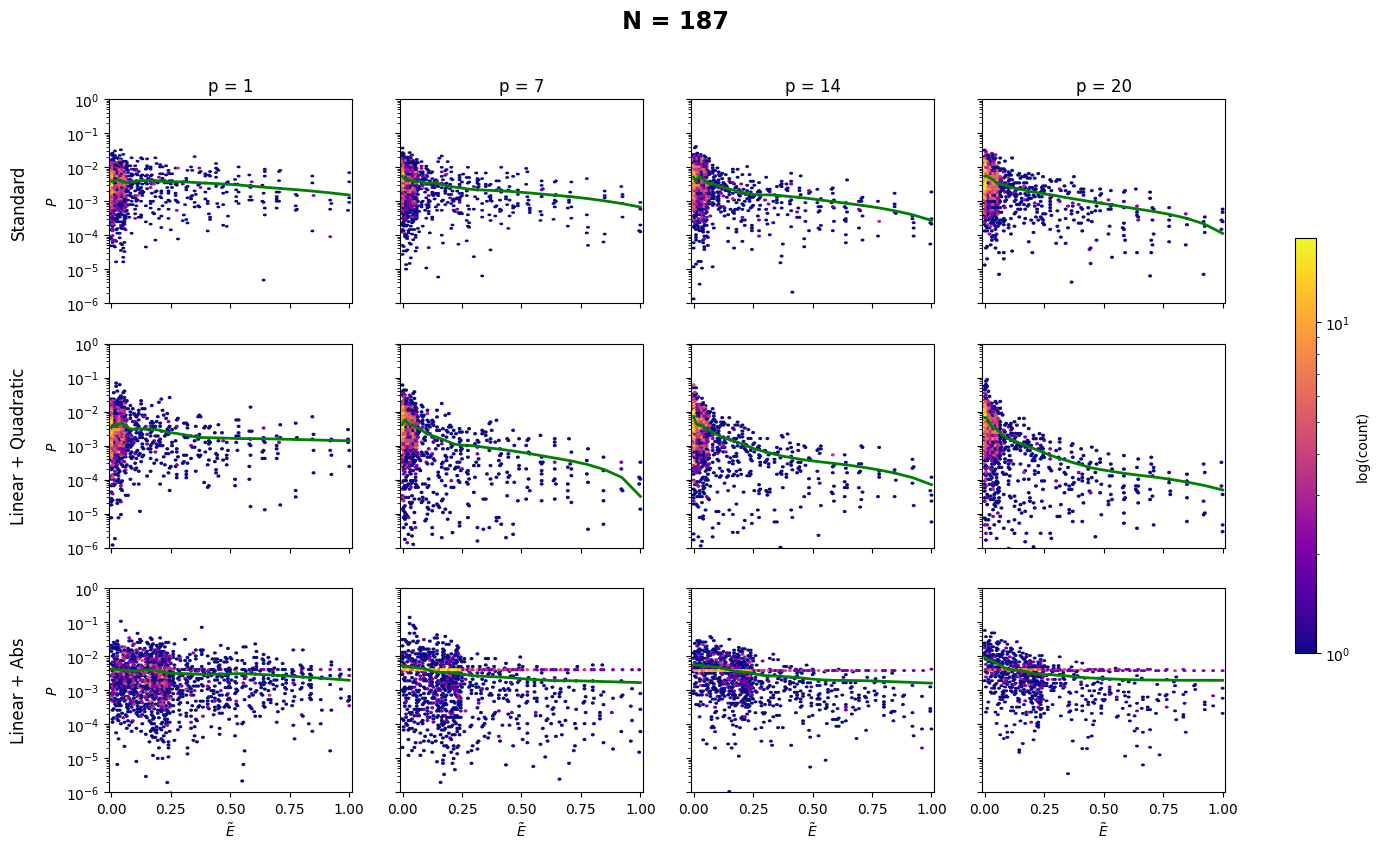

In [ ]:
N = 187


df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
layer_min = df_N['layers'].min()
layer_max = df_N.groupby('setup')['layers'].max().min()
n_samples = 4
target_layers = [int(round(x, 0)) for x in np.linspace(layer_min, layer_max, n_samples)]


df_N_target = df_N[df_N['layers'].isin(target_layers)].copy()
df_N_target = df_N.sort_values(by='layers')


nrows = 3
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(18, 9),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2)

for idx_col, p in enumerate(target_layers):
    for idx_row, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[idx_row][idx_col]
        df_p = df_N_target[(df_N_target['layers']==p) & (df_N_target['setup']==setup)]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=100, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,1)
        
        if idx_row == 0:
            ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == 2:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.25)
        ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=2)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.6)

fig.suptitle(f'N = {N}', x=0.41, ha='left', fontsize='xx-large', fontweight='bold')

setup_labels = ['Standard', 'Linear + Quadratic', 'Linear + Abs']
for idx_row, label in enumerate(setup_labels):
    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, label, va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


plt.show()

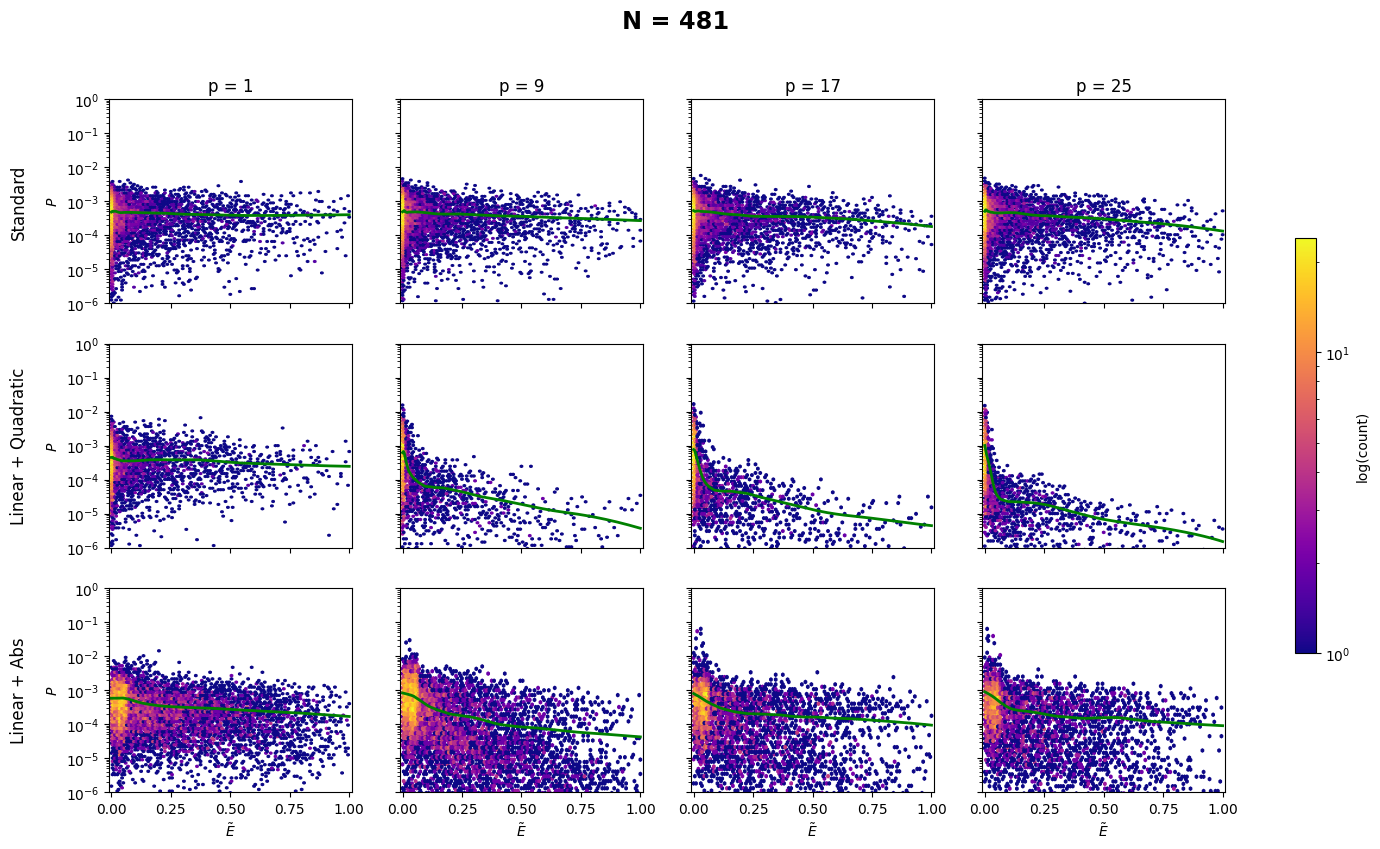

In [ ]:
N = 481
optimizer = 'L-BFGS-B'


df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
layer_min = df_N['layers'].min()
layer_max = df_N.groupby('setup')['layers'].max().min()
n_samples = 4
target_layers = [int(round(x, 0)) for x in np.linspace(layer_min, layer_max, n_samples)]


df_N_target = df_N[df_N['layers'].isin(target_layers)].copy()
df_N_target = df_N.sort_values(by='layers')


nrows = 3
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(18, 9),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2)

for idx_col, p in enumerate(target_layers):
    for idx_row, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[idx_row][idx_col]
        df_p = df_N_target[(df_N_target['layers']==p) & (df_N_target['setup']==setup)]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=100, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,1)
        
        if idx_row == 0:
            ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == 2:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.25)
        ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=2)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.6)

fig.suptitle(f'N = {N}', x=0.41, ha='left', fontsize='xx-large', fontweight='bold')

setup_labels = ['Standard', 'Linear + Quadratic', 'Linear + Abs']
for idx_row, label in enumerate(setup_labels):
    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, label, va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


plt.show()

## Using same initial parameters

In [ ]:
INIT_PARAMS = {
    'a': [2.278194341790279,1.8878746546919813],
    'b': [3.4748376816697872, 2.118867272280805],
    'c': [4.022993274680973, 0.8503996595801566]
}

### L-BFGS-B

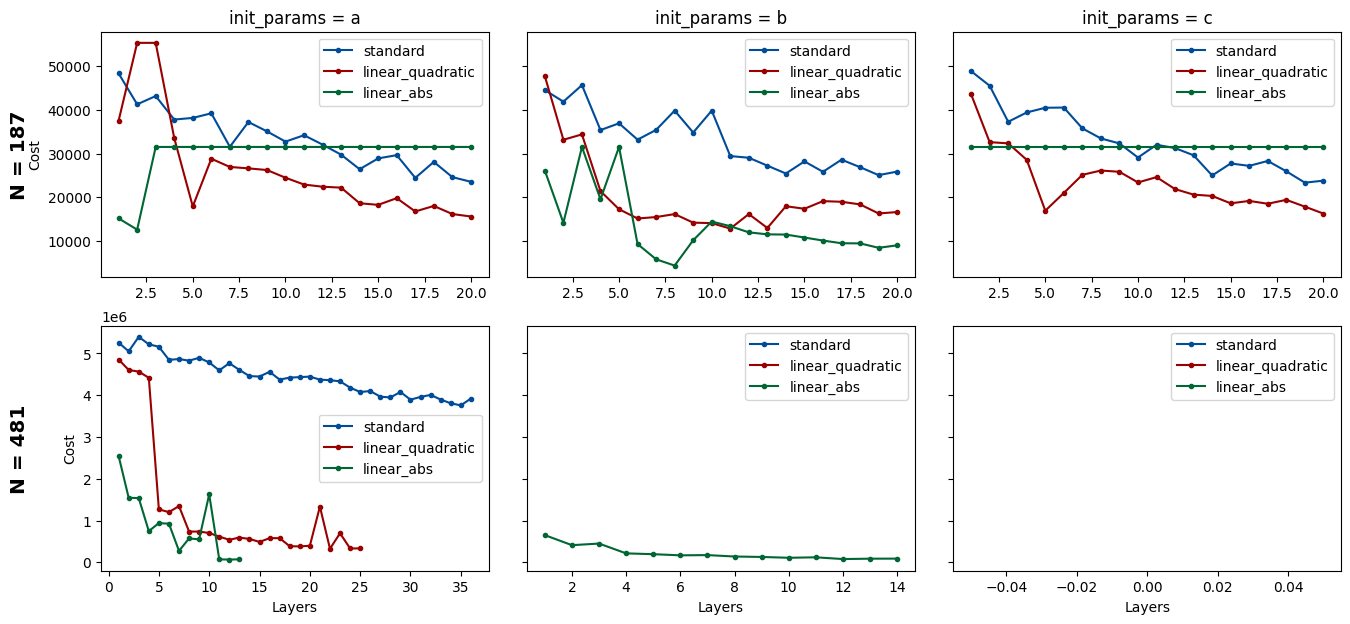

In [ ]:
extended_qaoa = False

fig, axs = plt.subplots(2, 3, figsize=(16, 7), sharey='row')
fig.subplots_adjust(wspace=0.1)

for idx_row, N in enumerate([187,481]):
    for idx_col, init_conf in enumerate(['a','b','c']):
        df_N = experiment_results[(experiment_results.N == N) & (experiment_results.optimizer == 'L-BFGS-B')
                                & (experiment_results.extended_qaoa == False)
                                & (experiment_results.angle_interpolation == True)
                                & (experiment_results.gamma_0 == round(INIT_PARAMS[init_conf][0], 3))
                                & (experiment_results.beta_0 == round(INIT_PARAMS[init_conf][1], 3))]
        for j, setup in enumerate(setups):
            df = df_N[df_N.setup == setup].copy()
            if setup == 'linear_abs':
                df['cost'] = np.power(df['cost'], 2)
            ax = axs[idx_row][idx_col]
            ax.plot('layers', 'cost', data=df, marker='.', color=plot_colors[j+1][0], label=setup)
            ax.legend(loc='best')

        if idx_col == 0:
            ax.set_ylabel('Cost')
        if idx_row == 0:
            ax.set_title(f'init_params = {init_conf}')
        if idx_row == 1:
            ax.set_xlabel('Layers')
    

    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2
    fig.text(0.08, y_center, f'N = {N}', va='center', ha='right', fontsize='x-large', fontweight='semibold', rotation=90)